#### Zemax accepts .bmp files hence this notebook is for converting .tif high quality satellite images to .bmp format

In [1]:
!pip install Pillow

In [3]:
from PIL import Image
import os

# Path to the folder containing your images
input_folder = r"C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.tif)"
output_folder = r"C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)"

# Make sure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tif")):
        # Open image
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Optional: Resize to 1024x1024 if not already
        img = img.resize((1024, 1024))

        # Convert and save as .bmp
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".bmp")
        img.save(output_path, format='BMP')

        print(f"Saved {output_path}")

Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\1.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\10.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\11.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\12.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\13.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\14.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\15.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\16.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\17.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\18.bmp
Saved C:\Users\sneha\OneDrive\Documents\test high quality satellite images (.bmp)\19.bmp
Saved C:\Users\sneha\O

#### Load and Visualize PSF Data (paraxial lens)

Loaded PSF shape: (2048, 2048)


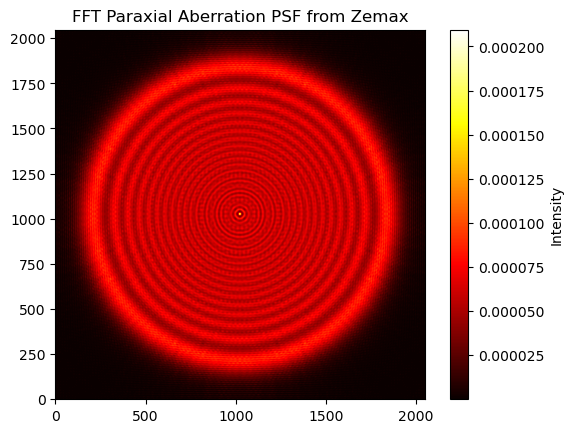

In [44]:
file_path = r"C:\Users\sneha\OneDrive\Documents\FFT PSF Data (paraxial lens).txt"

clean_data = []

# Read with UTF-16 encoding as Zemax typically uses that
with open(file_path, encoding='utf-16') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        try:
            # Replace Zemax 'XE' notation with standard 'E'
            line_fixed = line.replace('XE', 'E')
            row = [float(val) for val in line_fixed.split()]
            clean_data.append(row)
        except ValueError:
            continue  # Skip non-numeric lines

# Convert to NumPy array
psf = np.array(clean_data)

# Sanity check
print(f"Loaded PSF shape: {psf.shape}")

# Plot
plt.imshow(psf, cmap='hot', origin='lower')
plt.title("FFT Paraxial Aberration PSF from Zemax")
plt.colorbar(label='Intensity')
plt.show()

#### Estimate Blur Strength (sigma) and Kernel Size (k x k)

In [30]:
from scipy.optimize import curve_fit

# Gaussian model
def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y, offset):
    x, y = coords
    inner = ((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)
    return offset + amp * np.exp(-inner).ravel()

# Step 1: Locate PSF peak
max_idx = np.unravel_index(np.argmax(psf), psf.shape)
yc, xc = max_idx
print(f"PSF peak at: x = {xc}, y = {yc}")

# Step 2: Crop PSF around the peak
window_size = 50  # size of square region (can adjust)
half = window_size // 2
x_start = max(xc - half, 0)
x_end = min(xc + half, psf.shape[1])
y_start = max(yc - half, 0)
y_end = min(yc + half, psf.shape[0])

psf_crop = psf[y_start:y_end, x_start:x_end]

# Step 3: Set up meshgrid
x = np.arange(psf_crop.shape[1])
y = np.arange(psf_crop.shape[0])
x, y = np.meshgrid(x, y)

# Step 4: Initial guess for parameters
initial_guess = (
    psf_crop.max(),           # amplitude
    psf_crop.shape[1] / 2,    # x0
    psf_crop.shape[0] / 2,    # y0
    5,                        # sigma_x
    5,                        # sigma_y
    psf_crop.min()            # offset
)

# Step 5: Fit the Gaussian
popt, _ = curve_fit(
    gaussian_2d,
    (x, y),
    psf_crop.ravel(),
    p0=initial_guess,
    maxfev=10000
)

# Step 6: Extract fitted parameters
amp, x0, y0, sigma_x, sigma_y, offset = popt
print(f"Estimated σ_x: {sigma_x:.2f} pixels")
print(f"Estimated σ_y: {sigma_y:.2f} pixels")
sigma_mean = (sigma_x + sigma_y) / 2
print(f"Average σ (Gaussian blur): {sigma_mean:.2f} pixels")

PSF peak at: x = 1023, y = 1024
Estimated σ_x: 3.48 pixels
Estimated σ_y: 3.48 pixels
Average σ (Gaussian blur): 3.48 pixels


In [32]:
import math

# Calculate kernel size from estimated sigma
kernel_size = int(2 * math.ceil(3 * sigma_mean) + 1)
print(f"Estimated kernel size: {kernel_size} × {kernel_size}")

Estimated kernel size: 23 × 23


#### Load and Visualize PSF Data (plano convex lens)

Loaded PSF shape: (2048, 2048)


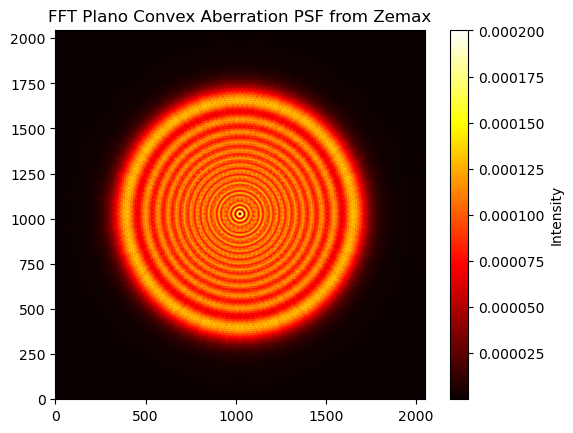

In [48]:
file_path = r"C:\Users\sneha\OneDrive\Documents\FFT PSF Data (plano convex lens).txt"

clean_data = []

# Read with UTF-16 encoding as Zemax typically uses that
with open(file_path, encoding='utf-16') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        try:
            # Replace Zemax 'XE' notation with standard 'E'
            line_fixed = line.replace('XE', 'E')
            row = [float(val) for val in line_fixed.split()]
            clean_data.append(row)
        except ValueError:
            continue  # Skip non-numeric lines

# Convert to NumPy array
psf = np.array(clean_data)

# Sanity check
print(f"Loaded PSF shape: {psf.shape}")

# Plot
plt.imshow(psf, cmap='hot', origin='lower')
plt.title("FFT Plano Convex Aberration PSF from Zemax")
plt.colorbar(label='Intensity')
plt.show()

#### Estimate Blur Strength (sigma) and Kernel Size (k x k)

In [50]:
from scipy.optimize import curve_fit

# Gaussian model
def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y, offset):
    x, y = coords
    inner = ((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)
    return offset + amp * np.exp(-inner).ravel()

# Step 1: Locate PSF peak
max_idx = np.unravel_index(np.argmax(psf), psf.shape)
yc, xc = max_idx
print(f"PSF peak at: x = {xc}, y = {yc}")

# Step 2: Crop PSF around the peak
window_size = 50  # size of square region (can adjust)
half = window_size // 2
x_start = max(xc - half, 0)
x_end = min(xc + half, psf.shape[1])
y_start = max(yc - half, 0)
y_end = min(yc + half, psf.shape[0])

psf_crop = psf[y_start:y_end, x_start:x_end]

# Step 3: Set up meshgrid
x = np.arange(psf_crop.shape[1])
y = np.arange(psf_crop.shape[0])
x, y = np.meshgrid(x, y)

# Step 4: Initial guess for parameters
initial_guess = (
    psf_crop.max(),           # amplitude
    psf_crop.shape[1] / 2,    # x0
    psf_crop.shape[0] / 2,    # y0
    5,                        # sigma_x
    5,                        # sigma_y
    psf_crop.min()            # offset
)

# Step 5: Fit the Gaussian
popt, _ = curve_fit(
    gaussian_2d,
    (x, y),
    psf_crop.ravel(),
    p0=initial_guess,
    maxfev=10000
)

# Step 6: Extract fitted parameters
amp, x0, y0, sigma_x, sigma_y, offset = popt
print(f"Estimated σ_x: {sigma_x:.2f} pixels")
print(f"Estimated σ_y: {sigma_y:.2f} pixels")
sigma_mean = (sigma_x + sigma_y) / 2
print(f"Average σ (Gaussian blur): {sigma_mean:.2f} pixels")

PSF peak at: x = 1023, y = 1010
Estimated σ_x: 7.70 pixels
Estimated σ_y: 2.75 pixels
Average σ (Gaussian blur): 5.23 pixels


In [52]:
# Calculate kernel size from estimated sigma
kernel_size = int(2 * math.ceil(3 * sigma_mean) + 1)
print(f"Estimated kernel size: {kernel_size} × {kernel_size}")

Estimated kernel size: 33 × 33


#### Load and Visualize PSF Data (biconvex lens)

Loaded PSF shape: (4096, 4096)


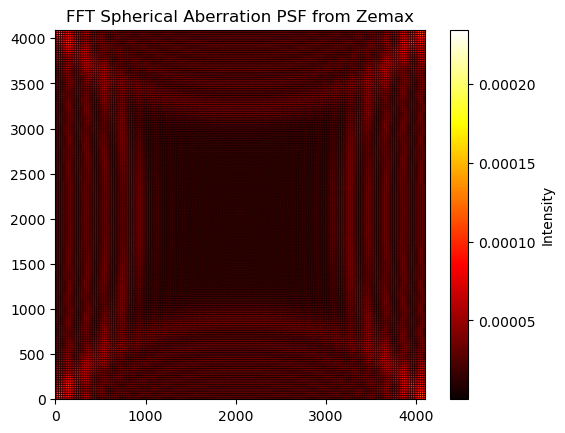

In [61]:
file_path = r"C:\Users\sneha\OneDrive\Documents\FFT PSF Data (biconvex lens).txt"

clean_data = []

# Read with UTF-16 encoding as Zemax typically uses that
with open(file_path, encoding='utf-16') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        try:
            # Replace Zemax 'XE' notation with standard 'E'
            line_fixed = line.replace('XE', 'E')
            row = [float(val) for val in line_fixed.split()]
            clean_data.append(row)
        except ValueError:
            continue  # Skip non-numeric lines

# Convert to NumPy array
psf = np.array(clean_data)

# Sanity check
print(f"Loaded PSF shape: {psf.shape}")

# Plot
plt.imshow(psf, cmap='hot', origin='lower')
plt.title("FFT Spherical Aberration PSF from Zemax")
plt.colorbar(label='Intensity')
plt.show()

#### Convert from .jpg to .tif

In [8]:
import os
import cv2

# Set your folder path
folder_path = r"C:\Users\sneha\OneDrive\Documents\Zemax Test Images (Plano Convex Lens)"

# Loop through all .jpg files
for filename in os.listdir(folder_path):
    if filename.lower().endswith(".jpg"):
        # Full path to .jpg
        jpg_path = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(jpg_path)

        # Create .tif filename
        tif_filename = os.path.splitext(filename)[0] + ".tif"
        tif_path = os.path.join(folder_path, tif_filename)

        # Save as .tif
        cv2.imwrite(tif_path, img)

        # Delete original .jpg file
        os.remove(jpg_path)

        print(f"✅ Converted: {filename} → {new_filename}")

✅ Converted: 26.jpg → 26.tif
✅ Converted: 27.jpg → 26.tif
✅ Converted: 28.jpg → 26.tif
✅ Converted: 29.jpg → 26.tif
✅ Converted: 30.jpg → 26.tif
✅ Converted: 32.jpg → 26.tif
✅ Converted: 33.jpg → 26.tif
✅ Converted: 34.jpg → 26.tif
✅ Converted: 35.jpg → 26.tif
✅ Converted: 36.jpg → 26.tif
✅ Converted: 37.jpg → 26.tif
✅ Converted: 38.jpg → 26.tif
✅ Converted: 39.jpg → 26.tif
✅ Converted: 40.jpg → 26.tif
✅ Converted: 41.jpg → 26.tif
✅ Converted: 42.jpg → 26.tif
✅ Converted: 43.jpg → 26.tif
✅ Converted: 44.jpg → 26.tif
✅ Converted: 45.jpg → 26.tif
✅ Converted: 46.jpg → 26.tif
✅ Converted: 47.jpg → 26.tif
✅ Converted: 48.jpg → 26.tif
✅ Converted: 49.jpg → 26.tif
✅ Converted: 50.jpg → 26.tif


In [10]:
import os
import cv2

# Set your folder path
folder_path = r"C:\Users\sneha\OneDrive\Documents\Zemax Test Images (Biconvex Lens)"

# Loop through all .jpg files
for filename in os.listdir(folder_path):
    if filename.lower().endswith(".jpg"):
        # Full path to .jpg
        jpg_path = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(jpg_path)

        # Create .tif filename
        tif_filename = os.path.splitext(filename)[0] + ".tif"
        tif_path = os.path.join(folder_path, tif_filename)

        # Save as .tif
        cv2.imwrite(tif_path, img)

        # Delete original .jpg file
        os.remove(jpg_path)

        print(f"✅ Converted: {filename} → {new_filename}")

✅ Converted: 51.jpg → 26.tif
✅ Converted: 52.jpg → 26.tif
✅ Converted: 53.jpg → 26.tif
✅ Converted: 54.jpg → 26.tif
✅ Converted: 55.jpg → 26.tif
✅ Converted: 56.jpg → 26.tif
✅ Converted: 57.jpg → 26.tif
✅ Converted: 58.jpg → 26.tif
✅ Converted: 59.jpg → 26.tif
✅ Converted: 60.jpg → 26.tif
✅ Converted: 61.jpg → 26.tif
✅ Converted: 62.jpg → 26.tif
✅ Converted: 63.jpg → 26.tif
✅ Converted: 64.jpg → 26.tif
✅ Converted: 65.jpg → 26.tif
✅ Converted: 66.jpg → 26.tif
✅ Converted: 67.jpg → 26.tif
✅ Converted: 68.jpg → 26.tif
✅ Converted: 69.jpg → 26.tif
✅ Converted: 70.jpg → 26.tif
✅ Converted: 71.jpg → 26.tif
✅ Converted: 72.jpg → 26.tif
✅ Converted: 73.jpg → 26.tif
✅ Converted: 74.jpg → 26.tif
✅ Converted: 75.jpg → 26.tif


#### End